### The Work Forward Method

문헌상에서 가장 흔한 Backtest 방법은 Walk forward 접근법이다. Walk Forward는 '과거에 이 전략을 사용했더라면 어떻게 됐을까?'에 대한 역사적 시뮬레이션이다. 각 전략 결정은 결정 이전에 발생했던 관측값에 바탕을 두고 있는 셈이다. Chapter 11에서 살펴본 것처럼 흠결 없는 Walk forward를 수행하는 것은 Data source, Market microstructure, Risk management, Performance measurement standards, multiple testing methods, experimental mathematics 등의 많은 노력이 필요한 과제다. 불행하게도 백테스트를 수행하는 포괄적 비법이란 없다. 정확성과 대표성을 위해 각 백테스트는 특정 전략에 대한 가정을 평가할 수 있도록 맞춤형이 돼야 한다.

Walk Forward는 두 가지 핵심 이점을 가진다

1. Walk Forward는 정확히 과거를 이해할 수 있다. 성과는 paper trading과 일치시킬 수 있다. 
2. 역사는 여과 장치이다. 따라서 purging이 적절히 구현되기만 하면 과거 데이터를 사용하는 것은 테스트셋이 샘플 외라는 것을 보장한다. `t1.index`는 훈련셋에 속하고, `t1.values`는 테스트셋에 속하는 등 정보 누수는 Walk Forward Backtest에서는 흔한 실수이다. Walk Forward Backtest에는 Embargo가 필요 없다. 훈련셋이 항상 테스트셋보다 이전에 있기 때문이다.

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('SPY', start = '2020-01-01', progress = False)

#### 1. Pitfalls of the Walk-Forward Method

Walk forward는 세 가지 주요 단점이 있다. 첫째, 단일 시나리오가 테스트되는데 이는 쉽게 과적합된다. 둘째, Walk Forward가 반드시 미래의 성과를 나타내지 않는다. 결과가 특정 데이터 포인트의 sequence에 의해 편향될 수 있기 때문이다. Walk Forward 방법을 지지하는 사람들은 대개 과거를 예측하는 것은 과다하게 낙관적 성과로 이끌 것이라고 주장한다. 하지만 종종 성과가 탁월한 모델을 관측값의 역시퀀스에 적합화하면 성과가 떨어지는 Walk Forward 백테스트를 초래한다. 실제로 Walk Forward 백테스트는 Walk-Back 백테스트만큼 과적합되기 쉽고, 관측값의 시퀀스를 바꾸면 일관성 없는 결과를 도출한다는 점이 바로 과적합의 증거이다. Walk Forward의 지지자들이 옳다면 Walk Back 백테스트도 체계적으로 Walk-Forward보다 뛰어난 성능을 발휘했어야 한다. 그렇지 않으므로 Walk forward를 지지하는 주요 주장은 근거가 약하다.

두 번째 단점은 보다 명확히 하고자 2007년 1월 1일부터 S&P500 데이터에 대해 Walk Forward로 백테스트한 주식 전략을 가정해 보자. 2009년 3월 15일까지 반등과 폭락을 거듭하면서 전략은 각 포지션에 대해 낮은 신뢰도로 시장 중립적으로 학습될 것이다. 그런 다음, 긴 주식 시장의 상승세가 데이터셋을 지배할 것이고, 2017년 1월 1일까지 매수 예측이 매도 에측보다 우세할 것이다. 정보를 2017년 1월 1일부터 2007년 1월 1일까지 역으로 했더라면 성과는 매우 달랐을 것이다. 특정한 시퀀스를 집중적으로 사용하면 Walk Forward로 선택한 전략은 큰 낭패를 볼 수 있다.

Walk Forward의 세 번째 단점은 초기 결정이 전체 표본 중 더 작은 부분을 활용해 이뤄졌다는 점이다. 준비 기간이 설정됐더라도 대부분의 정보는 의사결정의 작은 부분에만 사용된다. $T$중 $t_0$개의 관측값을 준비 기간으로 사용하는 전략을 고려해 보자. 이 전략은 의사결정의 초기 절반 $\left( \frac{T - t_0}{2}\right)$을 다음과 같이 평균 데이터 포인트 개수에 대해서 행한다.

$$\left( \frac{T - t_0}{2}\right)^{-1} \left( t_0 + \frac{T + t_0}{2}\right) \frac{T-t_0}{4} = \frac{1}{4}T + \frac{3}{4} t_0$$

이는 전체 관측값의 단지 $\frac{3}{4}\frac{t_0}{T} + \frac{1}{4}$ 부분에 불과하다. 비록 이 문제는 준비 기간을 길게 하면 완화되지만, 이렇게 하면 백테스트의 길이가 감소된다.

In [20]:
data['SMA_5'] = data['Close'].rolling(window = 5).mean()
data['SMA_20'] = data['Close'].rolling(window = 20).mean()

In [21]:
data['Signal'] = 0
data.loc[data['SMA_5'] > data['SMA_20'], 'Signal'] = 1
data.loc[data['SMA_5'] < data['SMA_20'], 'Signal'] = -1

In [22]:
data['Position'] = data['Signal'].shift(1)

In [23]:
data['Strategy_Return'] = data['Position'] * data['Close'].pct_change()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

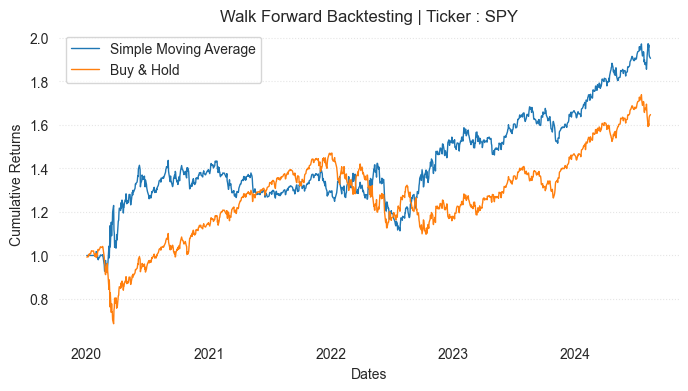

In [24]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(data['Cumulative_Strategy_Return'], lw = 1, label = 'Simple Moving Average')
ax.plot((1 + data['Close'].pct_change()).cumprod(), lw = 1, label = 'Buy & Hold')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Walk Forward Backtesting | Ticker : SPY')
plt.xlabel('Dates')
plt.ylabel('Cumulative Returns')
plt.show()